# WeatherPy
----

#### Note
* Instructions have been included for each segment. You do not have to follow them exactly, but they are included to help you think through the steps.

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
import time
from scipy.stats import linregress

# Import API key
import api_keys

from api_keys import weather_api_key


# Incorporated citipy to determine city based on latitude and longitude
from citipy import citipy

# Output File (CSV)
output_data_file = "output_data/cities.csv"

# Range of latitudes and longitudes
lat_range = (-90, 90)
lng_range = (-180, 180)

## Generate Cities List

In [2]:
lat_lngs = []
cities = []

# Create a set of random lat and lng combinations
lats = np.random.uniform(lat_range[0], lat_range[1], size=500)
lngs = np.random.uniform(lng_range[0], lng_range[1], size=500)
lat_lngs = zip(lats, lngs)

# Identify nearest city for each lat, lng combination
for lat_lng in lat_lngs:
    city = citipy.nearest_city(lat_lng[0], lat_lng[1]).city_name
    
    # If the city is unique, then add it to a our cities list
    if city not in cities:
        cities.append(city)

# Print the city count to confirm sufficient count
len(cities)

261

### Perform API Calls
* Perform a weather check on each city using a series of successive API calls.
* Include a print log of each city as it'sbeing processed (with the city number and city name).


In [3]:
# base_url in farenheit
base_url = "http://api.openweathermap.org/data/2.5/weather?units=Imperial&"

cloudiness = []
country = []
date = []
max_temp = []
humidity = []
lat = []
lng = []
wind_speed = []
city_name = []

# Loop through cities making the API call
i = 1
for city in cities:
    query_url = base_url + "appid=" + weather_api_key + "&q=" + city
    response = requests.get(query_url).json()
    
    try:
        cloudiness.append(response["clouds"]["all"])
        country.append(response["sys"]["country"])
        date.append(response["dt"])
        max_temp.append(response["main"]['temp_max'])
        humidity.append(response["main"]['humidity'])
        lat.append(response["coord"]["lat"])  
        lng.append(response["coord"]["lon"])
        wind_speed.append(response["wind"]["speed"])
        city_name.append(response["name"])
        print(f"Processing record {i}|{city}")
        i+=1
        
    except (KeyError):
        print("City name not available.")

Processing record 1|kapaa
Processing record 2|vallenar
Processing record 3|hilo
Processing record 4|kijang
Processing record 5|yellowknife
Processing record 6|chuy
City name not available.
Processing record 7|lagoa
Processing record 8|busselton
Processing record 9|nome
Processing record 10|kodiak
Processing record 11|kutulik
Processing record 12|port hedland
Processing record 13|georgetown
Processing record 14|bluff
Processing record 15|rikitea
Processing record 16|ushuaia
City name not available.
Processing record 17|sola
Processing record 18|new norfolk
Processing record 19|mataura
City name not available.
Processing record 20|kirakira
Processing record 21|port alfred
Processing record 22|carnarvon
Processing record 23|esperance
Processing record 24|le port
Processing record 25|khatanga
Processing record 26|moyale
Processing record 27|hermanus
Processing record 28|san patricio
Processing record 29|ormara
Processing record 30|hithadhoo
Processing record 31|provideniya
Processing recor

### Convert Raw Data to DataFrame
* Export the city data into a .csv.
* Display the DataFrame

In [4]:
# build the city data into a csv

city_df = pd.DataFrame({"City": city_name, 
                        "Cloudiness": cloudiness, 
                        "Country": country, 
                        "Date": date, 
                        "Humidity":humidity,
                        "Lat": lat,
                        "Lng": lng,
                        "Max Temp": max_temp,
                        "Wind Speed": wind_speed
                                         })

city_df = city_df.rename_axis('City ID')

city_df.head()

,City,Cloudiness,Country,Date,Humidity,Lat,Lng,Max Temp,Wind Speed
City ID,,,,,,,,,
0,Kapaa,75,US,1601128815,59,22.08,-159.32,73.0,9.08
1,Vallenar,0,CL,1601128983,42,-28.57,-70.76,64.4,4.68
2,Hilo,90,US,1601128613,83,19.73,-155.09,71.6,6.93
3,Gijang,40,KR,1601128983,68,35.24,129.21,68.0,12.75
4,Yellowknife,90,CA,1601128626,87,62.46,-114.35,42.8,5.82


In [5]:
city_df.to_csv("output_data/city_list.csv")

city_df.head()

,City,Cloudiness,Country,Date,Humidity,Lat,Lng,Max Temp,Wind Speed
City ID,,,,,,,,,
0,Kapaa,75,US,1601128815,59,22.08,-159.32,73.0,9.08
1,Vallenar,0,CL,1601128983,42,-28.57,-70.76,64.4,4.68
2,Hilo,90,US,1601128613,83,19.73,-155.09,71.6,6.93
3,Gijang,40,KR,1601128983,68,35.24,129.21,68.0,12.75
4,Yellowknife,90,CA,1601128626,87,62.46,-114.35,42.8,5.82


## Inspect the data and remove the cities where the humidity > 100%.
----
Skip this step if there are no cities that have humidity > 100%. 

In [6]:
humid_city = city_df.loc[city_df["Humidity"] > 100]

humid_city.head()
humid_city.count()

City          0
Cloudiness    0
Country       0
Date          0
Humidity      0
Lat           0
Lng           0
Max Temp      0
Wind Speed    0
dtype: int64

In [7]:
#  Get the indices of cities that have humidity over 100%.
index_list = city_df[(city_df["Humidity"] > 100)].index
                                  
index_list

Int64Index([], dtype='int64', name='City ID')

In [8]:
# Make a new DataFrame equal to the city data to drop all humidity outliers by index.
# Passing "inplace=False" will make a copy of the city_data DataFrame, which we call "clean_city_data".
clean_city_df = city_df.drop(index_list, inplace=False)
clean_city_df.count()

City          240
Cloudiness    240
Country       240
Date          240
Humidity      240
Lat           240
Lng           240
Max Temp      240
Wind Speed    240
dtype: int64

In [9]:
lats = clean_city_df["Lat"]
max_temps = clean_city_df["Max Temp"]
humidity = clean_city_df["Humidity"]
cloudiness = clean_city_df["Cloudiness"]
wind_speed = clean_city_df["Wind Speed"]

# Export the City_Data into a csv
clean_city_df.to_csv(output_data_file, index_label="City_ID")


## Plotting the Data
* Use proper labeling of the plots using plot titles (including date of analysis) and axes labels.
* Save the plotted figures as .pngs.

## Latitude vs. Temperature Plot

In [10]:
import datetime
city_date = datetime.datetime.fromtimestamp(int(city_df["Date"][0])).strftime('%Y-%m-%d')
city_date

'2020-09-26'

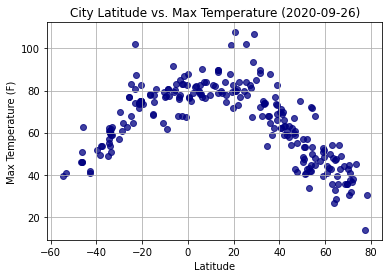

In [11]:
plt.scatter(city_df["Lat"], city_df["Max Temp"], marker = "o", color = "navy", alpha = .75)
plt.grid()
plt.xlabel("Latitude")
plt.ylabel("Max Temperature (F)")
plt.title(f"City Latitude vs. Max Temperature ({city_date})")
plt.savefig("output_data/Latitude vs. Max Temp plot.png")
plt.show()

## Latitude vs. Humidity Plot

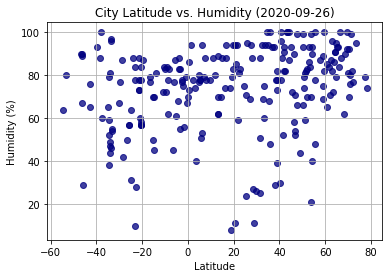

In [12]:
plt.scatter(city_df["Lat"], city_df["Humidity"], marker = "o", color = "navy", alpha = .75)
plt.grid()
plt.xlabel("Latitude")
plt.ylabel("Humidity (%)")
plt.title(f"City Latitude vs. Humidity ({city_date})")
plt.savefig("output_data/Latitude vs. Humidity plot.png")
plt.show()

## Latitude vs. Cloudiness Plot

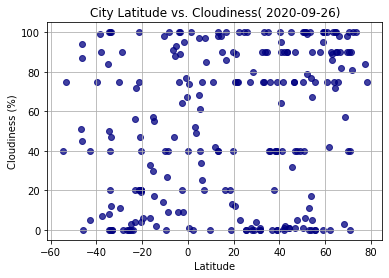

In [13]:
plt.scatter(city_df["Lat"], city_df["Cloudiness"], marker = "o", color = "navy", alpha = .75)
plt.grid()
plt.xlabel("Latitude")
plt.ylabel("Cloudiness (%)")
plt.title(f"City Latitude vs. Cloudiness( {city_date})")
plt.savefig("output_data/Latitude vs. Cloudiness plot.png")
plt.show()

## Latitude vs. Wind Speed Plot

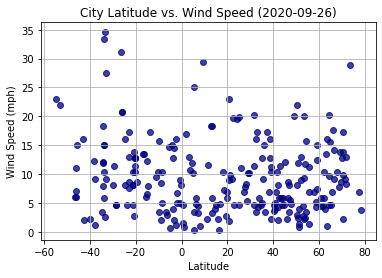

In [14]:
plt.scatter(city_df["Lat"], city_df["Wind Speed"], marker = "o", color = "navy", alpha = .75)
plt.grid()
plt.xlabel("Latitude")
plt.ylabel("Wind Speed (mph)")
plt.title(f"City Latitude vs. Wind Speed ({city_date})")
plt.savefig("output_data/Latitude vs. Wind Speed plot.png")
plt.show()

## Linear Regression

In [15]:
# Linear regression function
def linear_regression(x_values,y_values):
    (slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
    regress_values = x_values * slope + intercept
    line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
    plt.scatter(x_values, y_values)
    plt.plot(x_values,regress_values,"r-")
    return [line_eq, rvalue]

# Line annotation function
def annotate(line_eq, a, b):
    plt.annotate(line_eq,(a,b),fontsize=15,color="red")

####  Northern Hemisphere - Max Temp vs. Latitude Linear Regression

In [16]:
north = city_df.loc[city_df["Lat"] >= 0]
north_df = pd.DataFrame(north)

south = city_df.loc[city_df["Lat"] < 0]
south_df = pd.DataFrame(south)

####  Southern Hemisphere - Max Temp vs. Latitude Linear Regression

The r-squared is : 0.7251180862138585


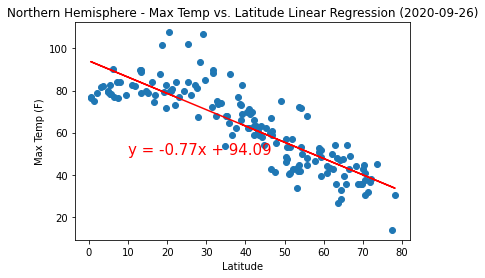

In [17]:
equation = linear_regression(north_df["Lat"], north_df["Max Temp"])

annotate(equation[0], 10, 50)

plt.title(f"Northern Hemisphere - Max Temp vs. Latitude Linear Regression ({city_date})")
plt.xlabel("Latitude")
plt.ylabel("Max Temp (F)")

print(f"The r-squared is : {equation[1]**2}")

plt.savefig("output_data/Northern Hemisphere - Max Temp vs. Latitude Linear Regression.png")

####  Northern Hemisphere - Humidity (%) vs. Latitude Linear Regression

The r-squared is : 0.03427365288894506


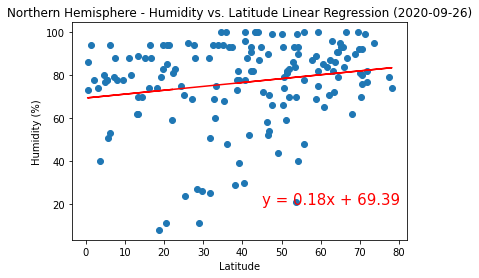

In [18]:
equation = linear_regression(north_df["Lat"], north_df["Humidity"])
annotate(equation[0], 45, 20)

plt.title(f"Northern Hemisphere - Humidity vs. Latitude Linear Regression ({city_date})")
plt.xlabel("Latitude")
plt.ylabel("Humidity (%)")

print(f"The r-squared is : {equation[1]**2}")

plt.savefig("output_data/Northern Hemisphere - Humidity vs. Latitude Linear Regression.png")

####  Southern Hemisphere - Humidity (%) vs. Latitude Linear Regression

The r-squared is : 0.004460305188611132


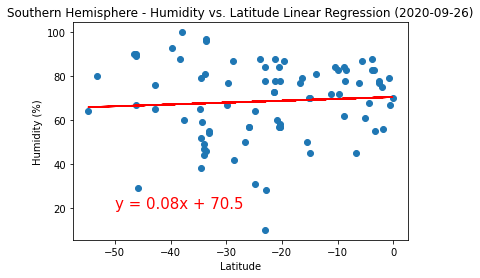

In [19]:
equation = linear_regression(south_df["Lat"], south_df["Humidity"])
annotate(equation[0], -50, 20)

plt.title(f"Southern Hemisphere - Humidity vs. Latitude Linear Regression ({city_date})")
plt.xlabel("Latitude")
plt.ylabel("Humidity (%)")

print(f"The r-squared is : {equation[1]**2}")

plt.savefig("output_data/Southern Hemisphere - Humidity vs. Latitude Linear Regression.png")

####  Northern Hemisphere - Cloudiness (%) vs. Latitude Linear Regression

The r-squared is : 0.0282045922677921


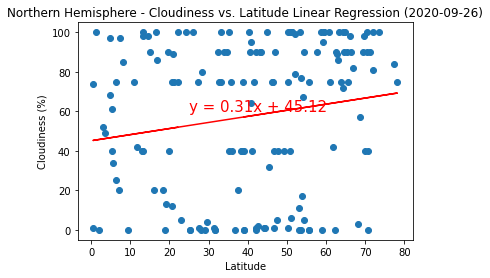

In [20]:
equation = linear_regression(north_df["Lat"], north_df["Cloudiness"])
annotate(equation[0], 25, 60)

plt.title(f"Northern Hemisphere - Cloudiness vs. Latitude Linear Regression ({city_date})")
plt.xlabel("Latitude")
plt.ylabel("Cloudiness (%)")

print(f"The r-squared is : {equation[1]**2}")

plt.savefig("output_data/Northern Hemisphere - Cloudiness vs. Latitude Linear Regression.png")

####  Southern Hemisphere - Cloudiness (%) vs. Latitude Linear Regression

The r-squared is : 0.0077331027411019675


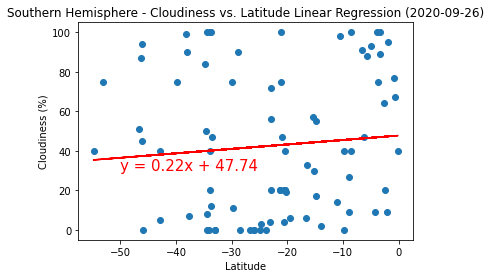

In [21]:
equation = linear_regression(south_df["Lat"], south_df["Cloudiness"])
annotate(equation[0], -50, 30)

plt.title(f"Southern Hemisphere - Cloudiness vs. Latitude Linear Regression ({city_date})")
plt.xlabel("Latitude")
plt.ylabel("Cloudiness (%)")

print(f"The r-squared is : {equation[1]**2}")

plt.savefig("output_data/Southern Hemisphere - Cloudiness vs. Latitude Linear Regression.png")

####  Northern Hemisphere - Wind Speed (mph) vs. Latitude Linear Regression

The r-squared is : 0.0031294022179174535


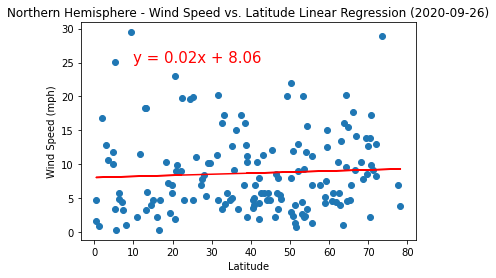

In [22]:
equation = linear_regression(north_df["Lat"], north_df["Wind Speed"])
annotate(equation[0], 10, 25)

plt.title(f"Northern Hemisphere - Wind Speed vs. Latitude Linear Regression ({city_date})")
plt.xlabel("Latitude")
plt.ylabel("Wind Speed (mph)")

print(f"The r-squared is : {equation[1]**2}")

plt.savefig("output_data/Northern Hemisphere - Wind Speed vs. Latitude Linear Regression.png")

####  Southern Hemisphere - Wind Speed (mph) vs. Latitude Linear Regression

The r-squared is : 0.06661207930288343


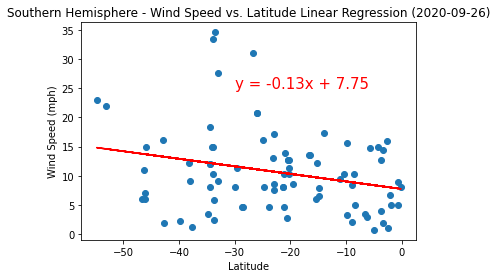

In [23]:
equation = linear_regression(south_df["Lat"], south_df["Wind Speed"])
annotate(equation[0], -30, 25)

plt.title(f"Southern Hemisphere - Wind Speed vs. Latitude Linear Regression ({city_date})")
plt.xlabel("Latitude")
plt.ylabel("Wind Speed (mph)")

print(f"The r-squared is : {equation[1]**2}")

plt.savefig("output_data/Southern Hemisphere - Wind Speed vs. Latitude Linear Regression.png")